<img src="front_page.png" align="center"/>

## Importing Libraries

In [1]:
#!pip install contractions
#!pip install tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import pandas as pd
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
import re                                           # Regular expressions library
import contractions                                 # Removing word contractions
import string
from textblob import TextBlob                       #For spelling correction
from nltk.corpus import stopwords                   #Stop words from NLTK
from nltk.stem import PorterStemmer                 #For stemming
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from tqdm import tqdm
from bs4 import BeautifulSoup
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
#nltk.download('popular') 

# 1. Reading Data

## 1.1 Importing the Data

In [3]:
data = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
target = data['sentiment']

In [5]:
data.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
data.shape

(25000, 3)

# 2.0 Data Preprocessing

## 2.1 Data Cleaning: Duplications

Checking if there any duplicate rows in the data

In [7]:
data.duplicated().value_counts()

False    25000
dtype: int64

There are no duplicate rows in the data.

## 2.2 Word distribution

In [8]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='alankar23', api_key='ZRwv1W442noLUYHuWRF3')

In [9]:
data['length'] = [len(x.split()) for x in data['review']]
hist = [go.Histogram(x=data['length'])]
py.iplot(hist)

## 2.3 Removing HTML tags.

In [10]:
#nltk.download('stopwords')  #~~~ Download stop words from NLTK 
#nltk.download('punkt')
stopword = stopwords.words('english')

In [11]:
def text_cleaner(data):
    global output 
    output = []
    for text in tqdm(data):
    # Removing htlm tags using regex and beatifulsoap
        text = re.sub(r'http\S+','', text)
        text = BeautifulSoup(text, 'lxml').get_text()
    # Removing english contractions form sentences
        text = contractions.fix(text)
        text = re.sub("\S*\d\S*", "", text).strip()
        text = re.sub('[^A-Za-z]+', ' ', text)
    # text = TextBlob(text).correct()
        text = ' '.join(word.lower() for word in text.split() if word.lower() not in stopword)
        output.append(text.strip())

## 2.4 Lemmatization

Lemmatization is done to convert the word to its root word. i.e stops is converted into stop to avoid increase in feature size.

In [12]:
def lemmetizer(data):
    global final
    final= []
    for words in tqdm(data):
        tokens = nltk.word_tokenize(words)
        sentence = ''.join(WordNetLemmatizer().lemmatize(alpha) for alpha in words)
        final.append(sentence.strip())

## 2.5 Word Clowd

In [13]:
positive = data[data['sentiment'] == 1]['review']
negative = data[data['sentiment'] == 0]['review']

In [74]:
def wordcloud(data,count):
    global sentiment
    words = []
    for sentence in data:
        text = nltk.word_tokenize(sentence)
        words.append(text)
    pos_words = Counter(list(itertools.chain(*words)))
    word = pos_words.most_common(count)
    sentiment = ' '.join(x[0] for x in word)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(sentiment) 
      # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

## 2.5.1 Word Clowd of most frequent words in positive reviews

In [14]:
text_cleaner(positive)
lemmetizer(output)

100%|███████████████████████████████████| 12500/12500 [00:55<00:00, 225.79it/s]


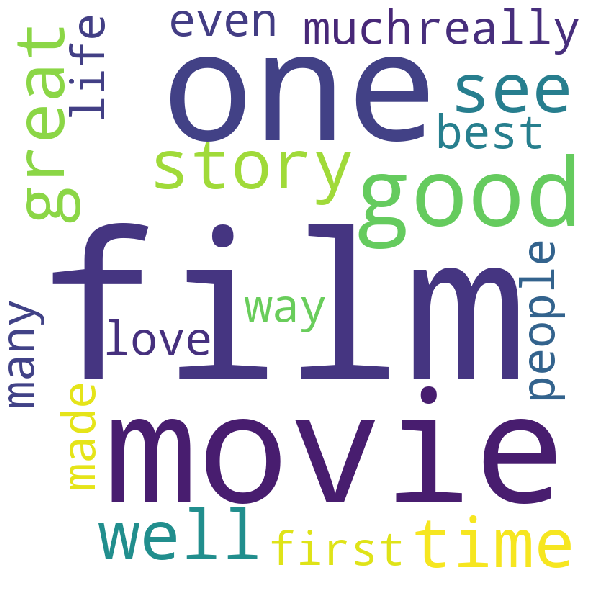

In [65]:
wordcloud(final,30)

## 2.5.2 Word Clowd of most frequent words in negative reviews

In [66]:
text_cleaner(negative)
lemmetizer(output)

100%|███████████████████████████████████| 12500/12500 [00:53<00:00, 232.94it/s]


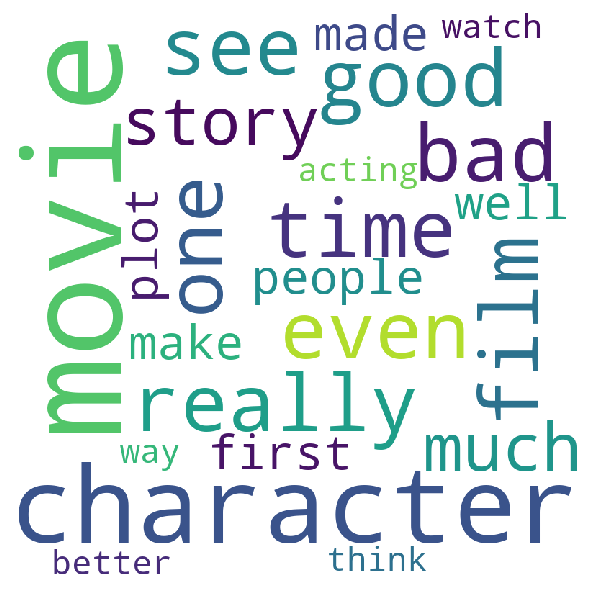

In [75]:
wordcloud(final,30)

# 4.0 Splitting the data

In [14]:
text_cleaner(data['review'])
lemmetizer(output)

100%|███████████████████████████████████| 25000/25000 [01:52<00:00, 222.82it/s]


In [20]:
xTrain , xTest , yTrain , yTest = train_test_split(final, target , test_size = 0.3)

In [15]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# 5. Vectorize the data

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, min_df =5) 

vectorizer.fit(xTrain)
xTrain = vectorizer.transform(xTrain)
xTest  = vectorizer.transform(xTest)

print(xTrain.shape, xTest.shape)

(17500, 22481) (7500, 22481)


In [ ]:
(17500, 64265) (7500, 64265)

# 6.1 Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable

In [0]:
c_grid = { 'C':np.arange(10**-3,10*2,0.05)}
lr = LogisticRegression(penalty ='l1', class_weight = 'balanced')

In [0]:
clf = RandomizedSearchCV(lr, c_grid, n_iter = 1000 , scoring = 'roc_auc', cv = k_fold, return_train_score = True, n_jobs = -1)
clf.fit(xTrain,yTrain)
print(clf.best_estimator_)
print(clf.score(xTrain,yTrain))

LogisticRegression(C=0.30100000000000005, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
0.9838614578747196


In [0]:
clf = LogisticRegression(C=0.301, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
clf.fit(xTrain,yTrain)
pred = clf.predict(xTest)

In [0]:
accuracy = round(accuracy_score(yTest,pred)*100,3)
precision = round(precision_score(yTest,pred)*100,3)
F1_score = round(f1_score(yTest,pred)*100,3)
roc_auc = round(roc_auc_score(yTest,pred)*100,3)
conf = confusion_matrix(yTest,pred)

In [0]:
table = PrettyTable()
table.add_column('Optimal C',['0.351'])
table.add_column('Roc Auc score',[roc_auc])
table.add_column('Accuracy',[accuracy])
table.add_column('Precison',[precision])
table.add_column('F1 Score',[F1_score])
print(table)

+-----------+---------------+----------+----------+----------+
| Optimal C | Roc Auc score | Accuracy | Precison | F1 Score |
+-----------+---------------+----------+----------+----------+
|   0.351   |     87.942    |  87.947  |  87.188  |  88.127  |
+-----------+---------------+----------+----------+----------+


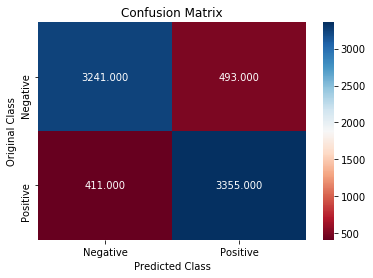

In [0]:
plt.title('Confusion Matrix')
labels = ['Negative','Positive']
sns.heatmap(conf,annot= True, cmap = 'RdBu',fmt='.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# 7.0 Naive  Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [0]:
alpha = {}
indx = 1
a = 0
MSE= []
a = 10**-2
while a < 10**2:
    NB = MultinomialNB(alpha = a , class_prior=None , fit_prior=True)
    scores = cross_val_score(NB, xTrain, yTrain, cv =k_fold , scoring='accuracy')
    error = 1 - scores.mean()
    MSE.append(error)
    alpha[error] = a
    a+=0.05
    indx  += 1

opt_alpha = alpha.get(min(MSE))
print('The optimal value of  alpha is {}' .format(round(opt_alpha,3)))

The optimal value of  alpha is 0.66


In [0]:
# Naive Bayes with Optimal alpha
multiNB = MultinomialNB(alpha =opt_alpha, class_prior=None , fit_prior=True)
multiNB.fit(xTrain, yTrain)
pred = multiNB.predict(xTest)

In [0]:
accuracy = round(accuracy_score(yTest,pred)*100,3)
precision = round(precision_score(yTest,pred)*100,3)
F1_score = round(f1_score(yTest,pred)*100,3)
roc_auc = round(roc_auc_score(yTest,pred)*100,3)
conf = confusion_matrix(yTest,pred)

In [0]:
table = PrettyTable()
table.add_column('Optimal C',['0.351'])
table.add_column('Roc Auc score',[roc_auc])
table.add_column('Accuracy',[accuracy])
table.add_column('Precison',[precision])
table.add_column('F1 Score',[F1_score])
print(table)

+-----------+---------------+----------+----------+----------+
| Optimal C | Roc Auc score | Accuracy | Precison | F1 Score |
+-----------+---------------+----------+----------+----------+
|   0.351   |     85.597    |   85.6   |  86.402  |  85.398  |
+-----------+---------------+----------+----------+----------+


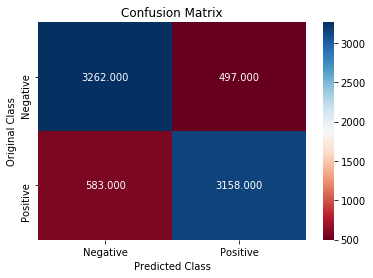

In [0]:
plt.title('Confusion Matrix')
labels = ['Negative','Positive']
sns.heatmap(conf,annot= True, cmap = 'RdBu',fmt='.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# 7.0 Random Forrest

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
param_grid = {'n_estimators':[x for x in range(100,1000)],'criterion':['gini', 'entropy'],'min_samples_split':[2,5,10],'min_samples_leaf':[2,5,10] }

In [48]:
clf = RandomForestClassifier(n_estimators= 500)
clf.fit(xTrain,yTrain)
print(clf.score(xTrain,yTrain))

1.0


In [51]:
clf.fit(xTrain,yTrain)
pred = clf.predict(xTest)
accuracy = round(accuracy_score(yTest,pred)*100,3)
precision = round(precision_score(yTest,pred)*100,3)
F1_score = round(f1_score(yTest,pred)*100,3)
roc_auc = round(roc_auc_score(yTest,pred)*100,3)
conf = confusion_matrix(yTest,pred)

In [52]:
table = PrettyTable()
#table.add_column('Optimal C',['0.351'])
table.add_column('Roc Auc score',[roc_auc])
table.add_column('Accuracy',[accuracy])
table.add_column('Precison',[precision])
table.add_column('F1 Score',[F1_score])
print(table)

+---------------+----------+----------+----------+
| Roc Auc score | Accuracy | Precison | F1 Score |
+---------------+----------+----------+----------+
|     86.379    |  86.373  |  85.464  |  86.46   |
+---------------+----------+----------+----------+


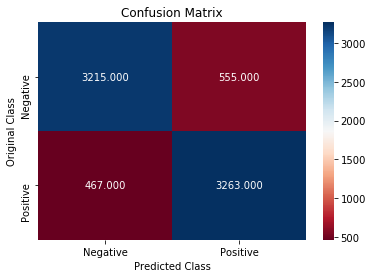

In [54]:
plt.title('Confusion Matrix')
labels = ['Negative','Positive']
sns.heatmap(conf,annot= True, cmap = 'RdBu',fmt='.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()